# Interactive clustering example

Here we will use the new interactive tool for interactive clustering.

You can integrate this with your workflow to fix clustering issues. To illustrate, I've duplicated the first part of the analysis template here. We then correct a clustering issue with the interactive clustering tool, and pipe the droplets DataFrame back into the rest of the pipeline (not shown here). 

### Step 0: Imports and config

Begin as normal. 

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
googlepath = "/content/drive/My Drive/"

In [18]:
pip install -U PyYAML

Requirement already up-to-date: PyYAML in /usr/local/lib/python3.6/dist-packages (5.3.1)


In [29]:
# basic imports
import yaml
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# kchip imports
import ii as kchip_io
import analyze as kchip_analyze

# Other
%matplotlib inline

# Read in config file
with open('{}Broad/kchip-master/kchip-master/Accessory/config/config24.yml'.format(googlepath), 'r') as ymlfile:
  config = yaml.load(ymlfile)
    
print(yaml.dump(config))

barcodes:
  cluster:
    eps: 0.01
    min_samples: 10
    offset:
    - 600
    - 600
    - 600
    points_to_cluster: 2000
  path: /content/drive/My Drive/Broad/kchip-master/kchip-master/Accessory/Notes.xlsx
image:
  base_path: /content/drive/My Drive/Chip24_data/
  bugs: 0
  dyes:
  - 1
  - 3
  - 2
  names:
    premerge: Chip24_premerge
    t0: Chip24_t0
    t1: Chip24_t1
    t2: Chip24_t2
  overlap: 0.05
  pixel_size: 6.5
  size: 1024
  well_start_image:
  - 1
  - 1
  well_start_xy:
  - 518
  - 434
well_mask:
  filename: /content/drive/My Drive/Broad/kchip-master/kchip-master/Accessory/Well
    Masks/k2_mask.tif
  pixel_size: 8.33625
  well_start_xy:
  - 242
  - 378



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  app.launch_new_instance()


In [0]:
fontsize = 14
plt.rcParams['axes.spines.right']=False
plt.rcParams['axes.spines.top']=False

plt.rcParams['axes.linewidth']=3
plt.rcParams['axes.labelsize']=fontsize
plt.rcParams['lines.linewidth']=2
plt.rcParams['xtick.labelsize']=fontsize
plt.rcParams['ytick.labelsize']=fontsize
plt.rcParams['axes.titlesize'] = fontsize
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.size']=fontsize
plt.rcParams['xtick.major.width']=1.5
plt.rcParams['ytick.major.width']=1.5
plt.rcParams['contour.negative_linestyle'] = 'solid'

plt.rcParams['savefig.bbox']='Tight'
plt.rcParams['pdf.fonttype'] = 42

### Step 1: Create droplets DataFrame

Here we won't run the code, instead we will just load the droplets DataFrame normally output by this cell from `droplets.csv`.

In [0]:
# Don't run for this example, instead just read in the droplets dataframe output by this cell
droplets = pd.read_csv('droplets.csv',index_col=0)

# # Initialize droplets DataFrame from images
# droplets, rotation_theta = kchip_analyze.initialize_droplets(config)

# print 'Rotation (degrees): ', rotation_theta*180/np.pi

# # Identify droplets in the same well from fit to masks
# droplets = kchip_analyze.fit_droplets_to_mask(config,droplets,rotation_theta)

# # Cluster droplets and map apriori labels to clusters
# droplets, centroids = kchip_analyze.identify_clusters(config,droplets,show=1)

# print 'Total droplets identified: ', droplets.shape[0]

Next, we will change a clustering parameter to force bad clustering, and then correct it using the tool.

See A3 in the below plot. 

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


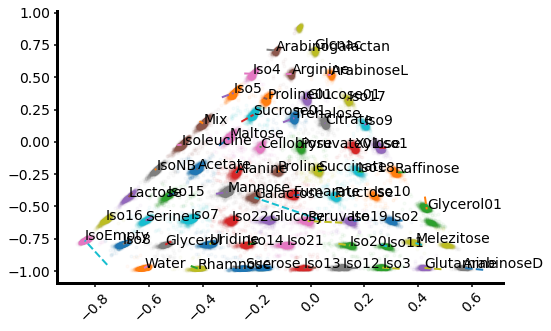

In [32]:
# Mess up clustering parameters to force bad clustering, for illustration
config['barcodes']['cluster']['eps'] = 0.03

fig, ax = plt.subplots(figsize=(8,5))
plt.xticks(rotation=45)


# Identify the clusters (using DBSCAN)
droplets = kchip_analyze.identify_clusters(config,droplets,show=1,ax=ax)

# Map the cluster centroids to labels
droplets = kchip_analyze.map_labels_to_clusters(config,droplets,show=1,ax=ax)

In [33]:
pip install bqplot

We can load the interactive tool to correct this. 

In [0]:
# Import the interactive tools
import interact as interact

# Create InteractiveCluster object
centroids = droplets.groupby('Cluster')[['PlaneX','PlaneY']].median().values
rc = interact.InteractiveCluster(droplets[['PlaneX','PlaneY']].values[:2000,:],centroids)

Don't forget to call `interact.bqplt.show()` in order to show the plot. You can now click on points to add a cluster, or click on the cluster centroid to remove the cluster. As you add and remove the points will re-cluster in response. 

In [25]:
# Show the plot
interact.bqplt.show()

# Change the point opacities for better viewing, as desired
rc.sca_points.default_opacities = [0.25]

After we are satisfied, we can then update the droplets DataFrame. 

In [0]:
# Update the droplets dataframe with new cluster assignments

droplets['Cluster']=rc.cluster(droplets[['PlaneX','PlaneY']].values)

Finally, remap the barcodes to the cluster centroids using `map_labels_to_clusters`.

/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


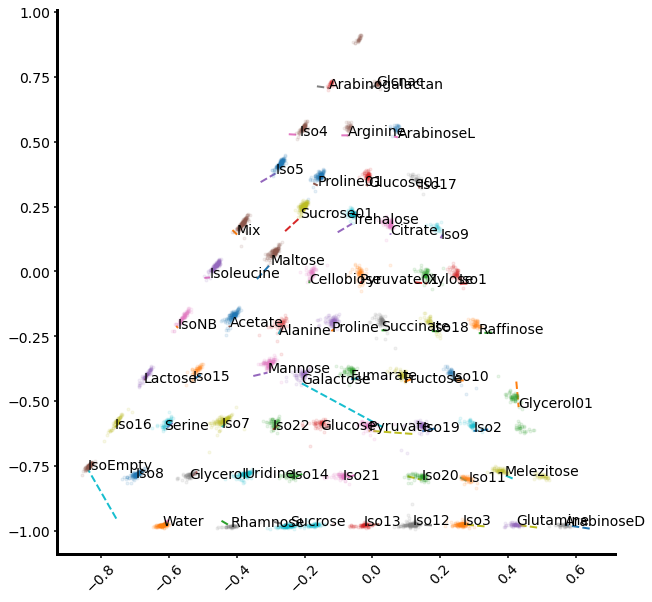

In [36]:
fig, ax = plt.subplots(figsize=(10,10))
plt.xticks(rotation=45)

# Use the updated cluster centroids from the interactive plot
droplets = kchip_analyze.map_labels_to_clusters(config,droplets,show=1,ax=ax)

# Replot the points to view the clusters

d = droplets.loc[:5e3] # only choose the first 5000 points so we don't overload matplotlib
for item in droplets['Cluster'].unique():
    xy = d.query('Cluster=='+str(item))[['PlaneX','PlaneY']].values
    ax.plot(xy[:,0],xy[:,1],'.',alpha=0.1)

The droplets DataFrame can then be carried forward through the rest of the analysis as usual. 

In [0]:
droplets.to_csv('droplets_1.csv')